# Second Microtask of Project Reporting CHAOSS Metrics

### Under the Guidance of [CHAOSS](https://chaoss.community/ "chaoss") (Community Health Analytics Open Source Software)

Microtasks are part of an exercise to identify potential candidates for Gsoc 2k'18 under CHAOSS org

#### Task: Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.

**Step1**: Import all the necessary modules and libraries

In [115]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from calendar import monthrange, month_name
from collections import defaultdict, OrderedDict
from dateutil.relativedelta import relativedelta
from pprint import pprint

import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Step2**:Define necessary parameters

**Note**: You should generate you own github api token [here](https://blog.github.com/2013-05-16-personal-api-tokens/) Otherwise, there's a much stringent rate limit and you may not be able to get all the data

In [46]:
# Elasticsearch URL i.e. the url at which elasticsearch instance is running.r
ES_URL = "http://localhost:9200" 

# Make an elasticsearch instance
es = Elasticsearch(ES_URL)

# URL of the repository to be analysed
org_name = "Cloud-CV"
repo_name = "EvalAI"

# Names of the indices by which the repository will be stored
enriched_index_name = "cloudcv_github"
raw_index_name = "cloudcv_github_raw"

# This token will allow us to call GitHub's api without being rate limited 
github_access_token = "" # Enter your own token

**Step2**: Use _p2o.py_ and _github api_ to retrieve the repositories and index it in Elasticsearch instance 

In [ ]:
subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name,
      '--index-enrich', enriched_index_name, '-e', ES_URL,
      '--no_inc', '--debug', 'github', org_name , repo_name,
      '-t', github_access_token, '--sleep-for-rate'])
print("")

**Step3**: Retrieve records for inspection using elasticsearch query on index

In [141]:
def retrieve_records(index=None):
    "Queries the elasticsearch instance and returns all the documents in the index."
    
    search_result = es.search(index=index, body={"query":{"match_all":{}}})
    total = search_result["hits"]["total"]
    query = {
                "size":total, 
            }
    query_result = es.search(index=index, body=query)
    results = [query_result["hits"]["hits"][i]["_source"] for i in range(query_result["hits"]["total"])]
    return results

In [51]:
# retrieve the indexed documents
results = retrieve_records(enriched_index_name)

In [54]:
# Inspect the content of document
results[0]

{'assignee_domain': None,
 'assignee_email': None,
 'assignee_geolocation': None,
 'assignee_location': None,
 'assignee_login': None,
 'assignee_name': None,
 'assignee_org': None,
 'author_name': 'Deshraj Yadav',
 'closed_at': '2016-10-21T03:10:50Z',
 'created_at': '2016-10-21T03:08:51Z',
 'github_repo': 'Cloud-CV/EvalAI',
 'grimoire_creation_date': '2016-10-21T03:08:51+00:00',
 'id': 184389777,
 'id_in_repo': '1',
 'is_github_issue': 1,
 'item_type': 'pull request',
 'labels': '',
 'metadata__enriched_on': '2018-03-26T11:22:45.914552',
 'metadata__gelk_backend_name': 'GitHubEnrich',
 'metadata__gelk_version': '0.30.23',
 'metadata__timestamp': '2018-03-26T04:36:54.005454+00:00',
 'metadata__updated_on': '2016-10-21T03:10:50+00:00',
 'offset': None,
 'origin': 'https://github.com/Cloud-CV/EvalAI',
 'pull_request': True,
 'repository': 'https://github.com/Cloud-CV/EvalAI',
 'state': 'closed',
 'tag': 'https://github.com/Cloud-CV/EvalAI',
 'time_open_days': 0.0,
 'time_to_close_days': 

**Step4**: Use Elasticsearch_dsl module for analysis

**Note**:

Elasticsearch DSL is a high-level library whose aim is to help with writing and running queries 

against Elasticsearch. It is built on top of the official low-level client (elasticsearch-py) 

In [55]:
s = Search(using=es, index=enriched_index_name) # Instantiate elasticsearch_dsl object

In [56]:
# select the fields we want in the response
s = s.source(['id', 'closed_at', 'created_at','time_open_days','time_to_close_days'])

#we are going to arrange all the documents according to when they were created in ascending order
s = s.sort({'created_at':{'order':'desc'}})
#create filter for issues created since last 6 months
s = s.filter("terms", item_type = ['issue']).filter('range', created_at ={'gte': 'now-6M'}) 
s = s[0:10000]

In [58]:
#inspect the query
s.to_dict()

{'_source': ['id',
  'closed_at',
  'created_at',
  'time_open_days',
  'time_to_close_days'],
 'from': 0,
 'query': {'bool': {'filter': [{'terms': {'item_type': ['issue']}},
    {'range': {'created_at': {'gte': 'now-6M'}}}]}},
 'size': 10000,
 'sort': [{'created_at': {'order': 'desc'}}]}

In [60]:
# execute the query
s = s.execute()

In [64]:
# inspect total number of issues
s['hits']['total']

109

In [70]:
pprint(s['hits']['hits'][0]['_source'])

{'closed_at': None, 'time_open_days': 2.57, 'created_at': '2...}


**step5**: create a list of issues

In [83]:
issue_data = []  # issue list
for hits in s :
    if(hits.time_to_close_days == None):
        hits.time_to_close_days = '0'
        hits.closed_at = 'Issue still open'
    issue_data.append({'issue_id':hits.id ,'time_to_open_days':hits.time_open_days,'created_at':hits.created_at,
                       'time_to_close_days':hits.time_to_close_days,'closed_at':hits.closed_at})

In [84]:
#inspect issue
issue_data[0]

{'closed_at': 'Issue still open',
 'created_at': '2018-03-23T21:41:21Z',
 'issue_id': 308187067,
 'time_to_close_days': '0',
 'time_to_open_days': 2.57}

**step6**: Convert to dataframe for further analysis

In [85]:
data = pd.DataFrame(issue_data) # create dataframe

In [86]:
# inspect dataframe
data.head()

,closed_at,created_at,issue_id,time_to_close_days,time_to_open_days
0,Issue still open,2018-03-23T21:41:21Z,308187067,0,2.57
1,Issue still open,2018-03-23T19:29:21Z,308153107,0,2.66
2,Issue still open,2018-03-22T07:56:21Z,307539020,0,4.14
3,Issue still open,2018-03-22T01:52:35Z,307477859,0,4.40
4,2018-03-22T08:39:54Z,2018-03-20T22:08:57Z,307056762,1.44,1.44


In [125]:
# rearange columns
data = data[['issue_id','time_to_open_days','time_to_close_days','created_at','closed_at']]

**Step7**: Fill the missing values

In [126]:
data.fillna(0, inplace=True) # we fill the missing values with 0

In [127]:
data.head() # inspect

,issue_id,time_to_open_days,time_to_close_days,created_at,closed_at
0,308187067,2.57,0.00,2018-03-23T21:41:21Z,Issue still open
1,308153107,2.66,0.00,2018-03-23T19:29:21Z,Issue still open
2,307539020,4.14,0.00,2018-03-22T07:56:21Z,Issue still open
3,307477859,4.40,0.00,2018-03-22T01:52:35Z,Issue still open
4,307056762,1.44,1.44,2018-03-20T22:08:57Z,2018-03-22T08:39:54Z


In [128]:
data['time_to_close_days'] = data['time_to_close_days'].astype('float') # change datatype for smooth plotting

### Vizualize Result

Let us first Inspect the time to open and time to close issues seperately by using seaborn library

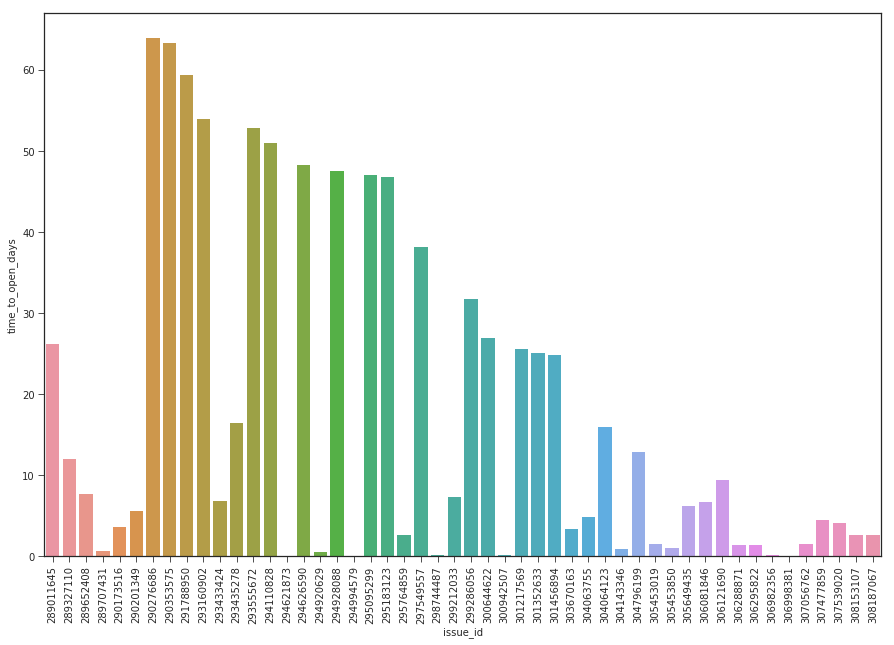

In [129]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of plot
fig.set_size_inches(15, 10)
sns.set_style("whitegrid")
sns.barplot(x="issue_id", y="time_to_open_days", data=data.iloc[:50,:],ax=ax,)
for item in ax.get_xticklabels():
    item.set_rotation(90)

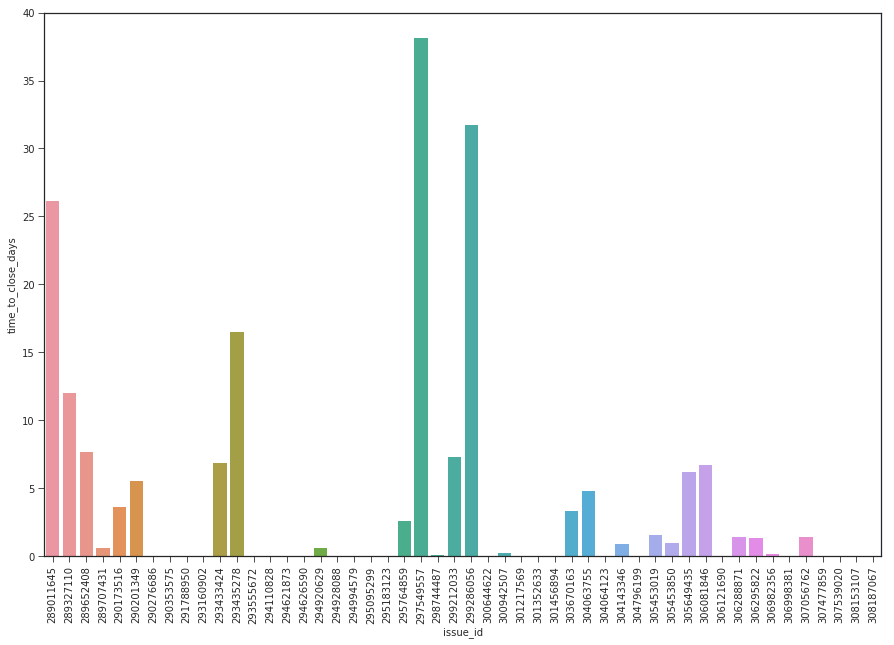

In [130]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of plot
fig.set_size_inches(15, 10)
sns.set_style("whitegrid")
sns.barplot(x="issue_id", y="time_to_close_days", data=data.iloc[:50,:], ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(90)

### Final Result

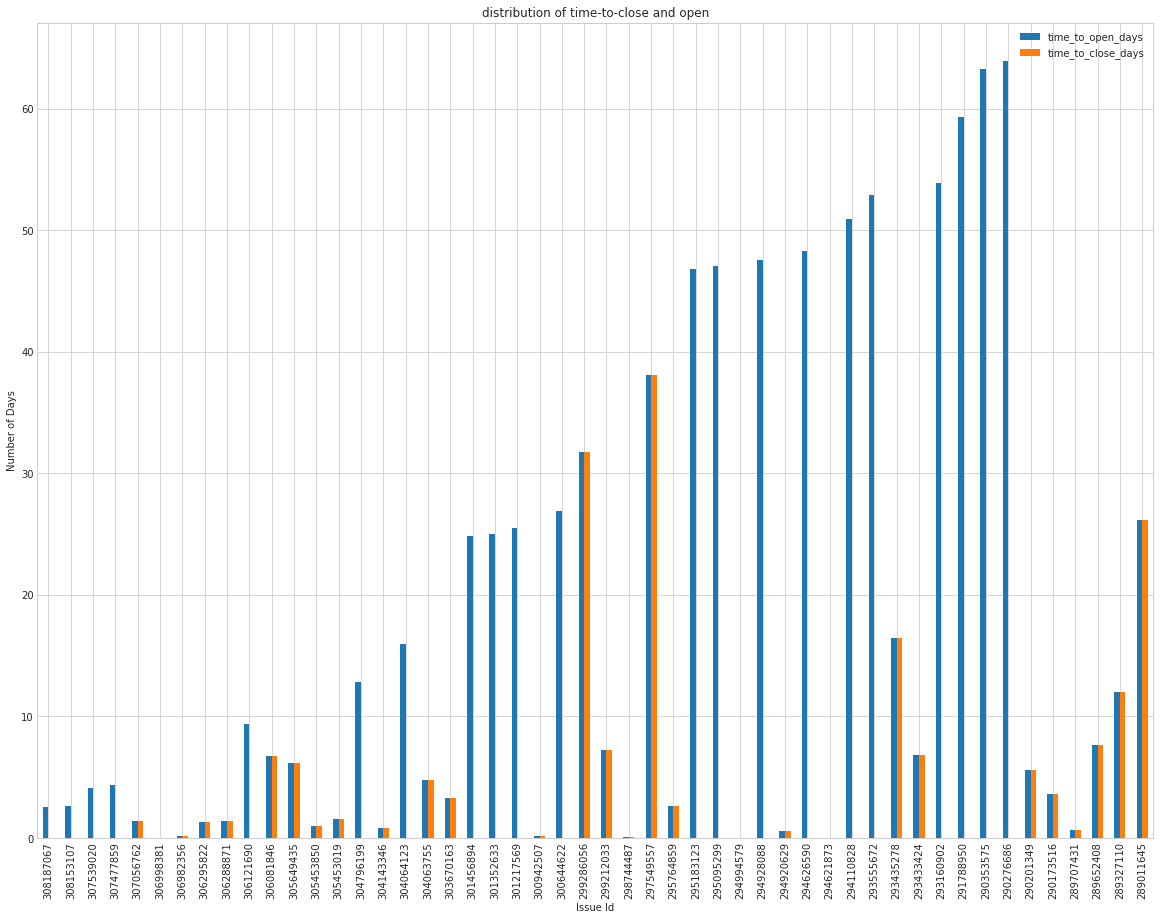

In [139]:
ax=data.iloc[:50,:3].plot.bar(x="issue_id", figsize=(20,15),title='distribution of time-to-close and open')
ax.set_ylabel("Number of Days", fontsize=10)
ax.set_xlabel("Issue Id", fontsize=10)
for item in ax.get_xticklabels():
    item.set_rotation(90)

**Final step**: Save the plot

In [ ]:
plt.savefig('Microtask2Plot')